# Faster R-CNNColab実装！
コードにちょくちょく至らぬところはあると思いますがご容赦願います

## モジュールのインポート

In [1]:
import numpy as np 
from PIL import Image
from glob import glob
import xml.etree.ElementTree as ET 
import cv2
 
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import TensorDataset
import os

## ハイパーパラメータ、pathの指定

In [2]:
#pathの指定(データセットの展開場所に応じて変えて下さい)
bdd_xml="D:/other/colab_frcnn/smallbdd/smallbdd/xml"
bdd_img="D:/other/colab_frcnn/smallbdd/smallbdd/img"
test_path="D:/other/colab_frcnn/smallbdd/smallbdd/test"

#datasetのクラス指定
dataset_class=['person', 'traffic light', 'train', 'traffic sign', 'rider', 'car', 'bike', 'motor', 'truck', 'bus']
#表示したいラベルの色の指定
#注意！！一番最初は背景クラスを示すので(0,0,0)にする
colors = ((0,0,0),(255,0,0),(0,255,0),(0,0,255),(100,100,100),(50,50,50),(255,255,0),(255,0,255),(0,255,255),(100,100,0),(0,100,100))

#ハイパーパラメータの指定
epochs=3
batch_size=1
scale=720#画像のスケール設定(縦の大きさを入力)


#使用デバイスの確認
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
print(device)
device = "cpu"

cuda


## その1データの読み込み（dataloaderの作成）

In [3]:

class xml2list(object):
    
    def __init__(self, classes):
        self.classes = classes
        
    def __call__(self, xml_path):
        
        ret = []
        xml = ET.parse(xml_path).getroot()
        
        boxes = []
        labels = []
        zz=0
        
        for zz,obj in enumerate(xml.iter('object')):
            
            label = obj.find('name').text
          
            ##指定クラスのみ

            if label in self.classes :
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(self.classes.index(label))
            else:
                continue
            
        num_objs = zz +1

        anno = {'bboxes':boxes, 'labels':labels}

        return anno,num_objs

In [4]:
class MyDataset(torch.utils.data.Dataset):
    
        def __init__(self,image_dir,xml_paths,scale,classes):
            
            super().__init__()
            self.image_dir = image_dir
            self.xml_paths = xml_paths
            self.image_ids = sorted(glob('{}/*'.format(xml_paths)))
            self.scale=scale
            self.classes=classes
            
        def __getitem__(self, index):
    
            transform = transforms.Compose([
                                            transforms.ToTensor()
            ])
    
            # 入力画像の読み込み
            image_id=self.image_ids[index].split("\\")[-1].split(".")[0]
            image = Image.open(f"{self.image_dir}/{image_id}.jpg")
            
            
            #画像のスケール変換
            t_scale_tate=self.scale ##目標のスケール(縦)
            #縮小比を計算
            ratio=t_scale_tate/image.size[1]
            ##目標横スケールを計算
            t_scale_yoko=image.size[0]*ratio
            t_scale_yoko=int(t_scale_yoko)
            
            #print('縮小前:',image.size)
            #print('縮小率:',ratio)
            #リサイズ
            image = image.resize((t_scale_yoko,t_scale_tate))
            #print('縮小後:',image.size)
  
            image = transform(image)
        
            transform_anno = xml2list(self.classes)
            path_xml=f'{self.xml_paths}/{image_id}.xml'
            

            annotations,obje_num= transform_anno(path_xml)

            boxes = torch.as_tensor(annotations['bboxes'], dtype=torch.int64)
            labels = torch.as_tensor(annotations['labels'], dtype=torch.int64)

          
            #bboxの縮小
            #print('縮小前:',boxes)
            boxes=boxes*ratio
            #print('縮小後:',boxes)
        
            area = (boxes[:, 3]-boxes[:, 1]) * (boxes[:, 2]-boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)

            iscrowd = torch.zeros((obje_num,), dtype=torch.int64)

            target = {}
            target["boxes"] = boxes
            target["labels"] = labels+1
            target["image_id"] = torch.tensor([index])
            target["area"] = area
            target["iscrowd"] = iscrowd
            return image, target,image_id
        
        def __len__(self):

            return len(self.image_ids)

In [5]:
def dataloader (data,dataset_class,batch_size,scale=720):
    xml_paths=data[0]
    image_dir1=data[1]
    dataset = MyDataset(image_dir1,xml_paths,scale,dataset_class)

    #データのロード
    torch.manual_seed(2020)
    def collate_fn(batch):
        return tuple(zip(*batch))

    train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_fn)
    

    return train_dataloader

# modelの定義

In [6]:
def model ():
    #モデルの定義
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    num_classes=len(dataset_class)+1
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model



# train

In [7]:
data_ALL=[bdd_xml,bdd_img]
train_dataloader=dataloader(data_ALL,dataset_class,batch_size,scale)

model=model()
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = epochs




model.to(device)

model.train()#学習モードに移行

loss_list=[]
for epoch in range(num_epochs):
    loss_epo=[]
    
    for i, batch in enumerate(train_dataloader):
        
 
        images, targets, image_ids = batch#####　batchはそのミニバッジのimage、tagets,image_idsが入ってる
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        
        ##学習モードでは画像とターゲット（ground-truth）を入力する
        ##返り値はdict[tensor]でlossが入ってる。（RPNとRCNN両方のloss）
        loss_dict= model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        #lossの保存
        loss_epo.append(loss_value)
 
        if (i+1) % 10== 0:
          print(f"epoch #{epoch+1} Iteration #{i+1} loss: {loss_value}") 
          
        
    #Epochごとのlossの保存
    loss_list.append(np.mean(loss_epo))
    torch.save(model, 'model.pt')

epoch #1 Iteration #10 loss: 1.2625062465667725
epoch #1 Iteration #20 loss: 1.3832104206085205
epoch #1 Iteration #30 loss: 0.7173106074333191
epoch #1 Iteration #40 loss: 1.368125081062317
epoch #1 Iteration #50 loss: 1.0480215549468994
epoch #1 Iteration #60 loss: 1.460946798324585
epoch #1 Iteration #70 loss: 1.1640323400497437
epoch #1 Iteration #80 loss: 0.865963339805603
epoch #1 Iteration #90 loss: 1.5161783695220947
epoch #1 Iteration #100 loss: 1.6539721488952637
epoch #1 Iteration #110 loss: 1.6641638278961182
epoch #1 Iteration #120 loss: 1.330315351486206
epoch #2 Iteration #10 loss: 1.4716134071350098
epoch #2 Iteration #20 loss: 1.4911084175109863
epoch #2 Iteration #30 loss: 0.5831763744354248
epoch #2 Iteration #40 loss: 1.6589175462722778
epoch #2 Iteration #50 loss: 1.1251500844955444
epoch #2 Iteration #60 loss: 1.1908217668533325
epoch #2 Iteration #70 loss: 1.3673632144927979
epoch #2 Iteration #80 loss: 1.3034237623214722
epoch #2 Iteration #90 loss: 1.0637651681

# Test
学習結果をもとに結果をテスト

In [8]:
import cv2
import glob
import matplotlib.pyplot as plt

data_class=dataset_class
data_class.insert(0, "__background__")
classes = tuple(data_class)


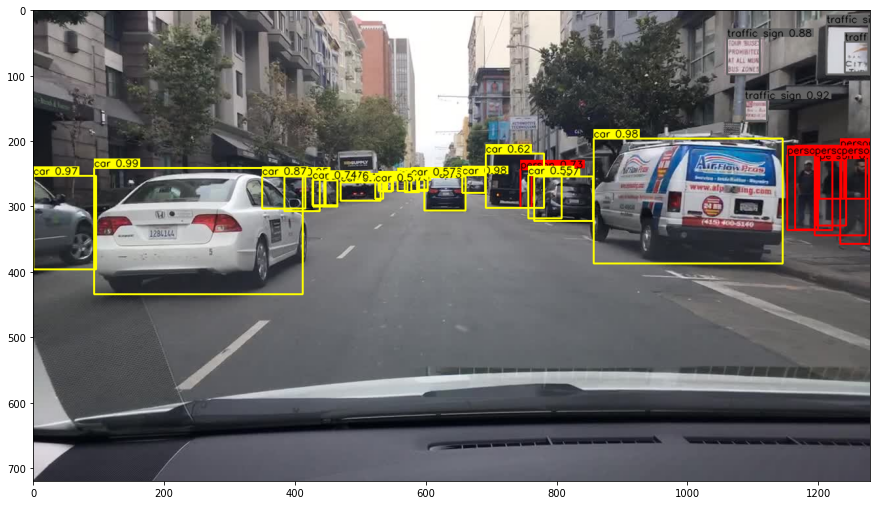

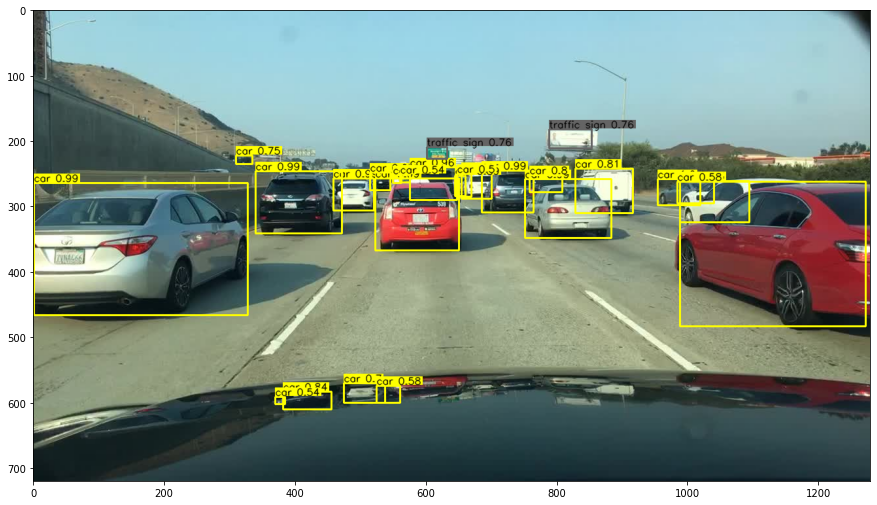

In [9]:
model.to(device)

model.eval()
for imgfile in sorted(glob.glob(test_path+'/*')):
    
    img = cv2.imread(imgfile)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_tensor = torchvision.transforms.functional.to_tensor(img)

    with torch.no_grad():
        prediction = model([image_tensor.to(device)])
    
    for i,box in enumerate(prediction[0]['boxes']):
        score = prediction[0]['scores'][i].cpu().numpy()
        if score > 0.5:
            score = round(float(score),2)
            cat = prediction[0]['labels'][i].cpu().numpy()
            txt = '{} {}'.format(classes[int(cat)], str(score))
            font = cv2.FONT_HERSHEY_SIMPLEX
            cat_size = cv2.getTextSize(txt, font, 0.5, 2)[0]
            c = colors[int(cat)]
            box=box.cpu().numpy().astype('int')
            cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), c , 2)
            cv2.rectangle(img,(box[0], box[1] - cat_size[1] - 2),(box[0] + cat_size[0], box[1] - 2), c, -1)
            cv2.putText(img, txt, (box[0], box[1] - 2), font, 0.5, (0, 0, 0), thickness=1, lineType=cv2.LINE_AA)


    plt.figure(figsize=(15,10))
    plt.imshow(img)
plt.show()